<a href="https://colab.research.google.com/github/ikramnaser/Data-Science/blob/main/picture_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithms For Massive Data

## Picture Recognizer Project
### by Ikram Ait Taleb Naser

## Importing libraries

In [9]:
from google.colab import files
import os, random, requests, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import hashlib
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil




## loading Dataset

In [10]:

!pip install -q kaggle tensorflow matplotlib pandas numpy seaborn requests pillow


warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)

uploaded = files.upload()  # Upload your kaggle.json file here


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -q amazon-books-reviews.zip

# Load dataset
books_data = pd.read_csv('books_data.csv')

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Books_rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y
y
replace books_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Exploratory Data Analysis

Dataset shape: (212404, 10)
Memory usage: 16.21 MB
Non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB
None

Missing Values (%):
               Missing    Percent
ratingsCount    162652  76.576712
publisher        75886  35.727199
description      68442  32.222557
image            52075  24.516958
categories       41199  19.39652

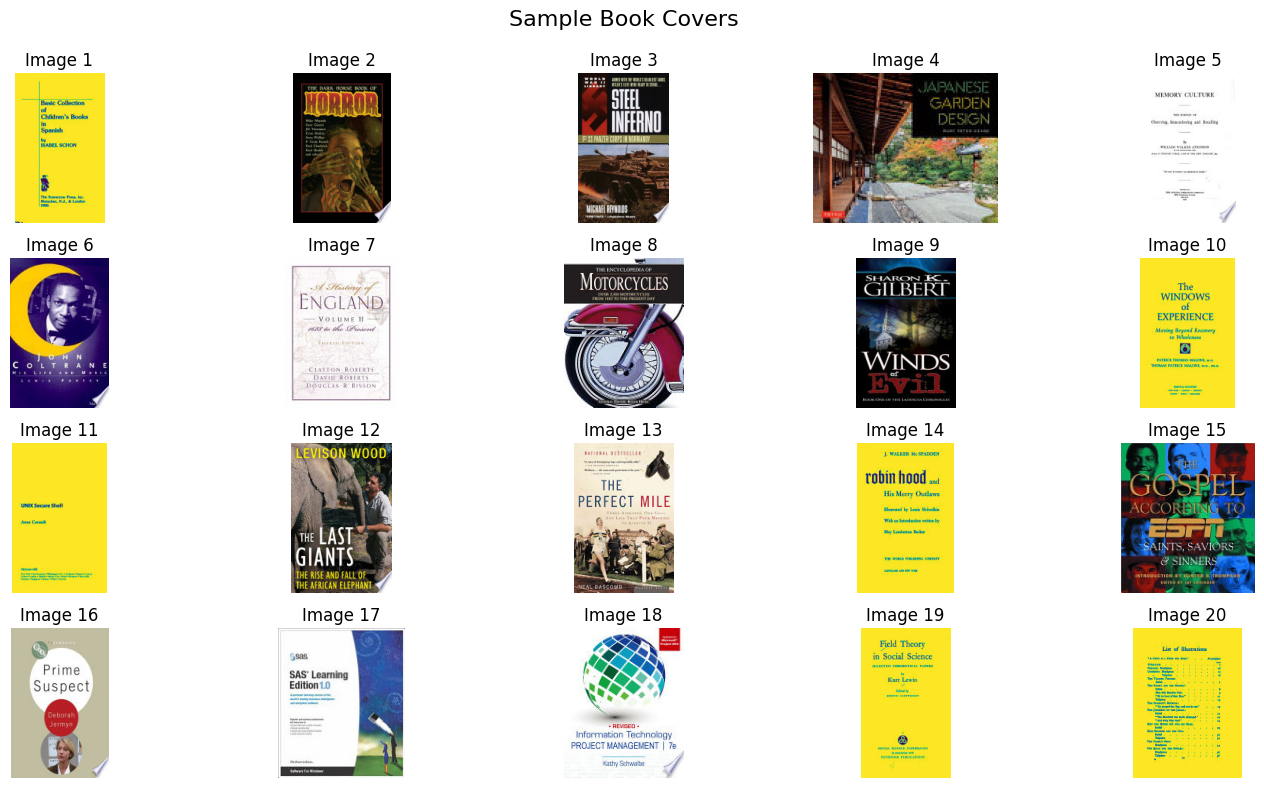

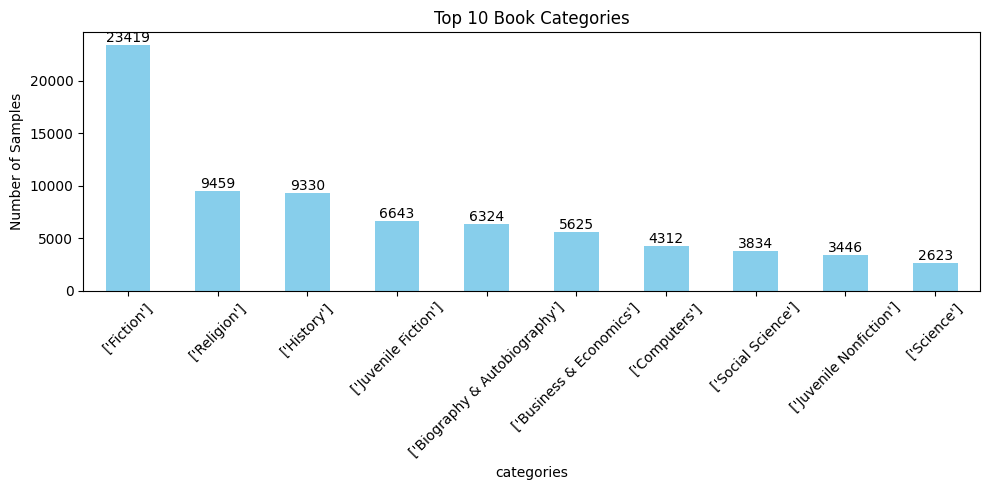

In [11]:
# Dataset info
print("Dataset shape:", books_data.shape)
print("Memory usage: {:.2f} MB".format(books_data.memory_usage().sum() / 1024**2))
print("Non-null counts:")
print(books_data.info())

# Missing values
missing = books_data.isnull().sum()
missing_percent = (missing / len(books_data)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
print("\nMissing Values (%):")
print(missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False))


# Check image URLs
print("\nImage URL Coverage:")
if 'image' in books_data.columns:
    total = books_data.shape[0]
    non_null = books_data['image'].notna().sum()
    print(f"- Non-null image URLs: {non_null} ({non_null/total*100:.2f}%)")

    # Sample a few images
    sample_urls = books_data['image'].dropna().sample(5).tolist()
    for i, url in enumerate(sample_urls):
        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
            else:
                print(f"Image {i+1}: ✗ Failed (HTTP {response.status_code})")
        except Exception as e:
            print(f"Image {i+1}: ✗ Error ({str(e)})")

    # Show sample images
    plt.figure(figsize=(15, 8))
    shown = 0
    for url in books_data['image'].dropna().sample(40):
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content))
            plt.subplot(4, 5, shown + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image {shown+1}")
            shown += 1
            if shown == 20: break
        except:
            continue
    plt.tight_layout()
    plt.suptitle("Sample Book Covers", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()


category_counts = books_data['categories'].value_counts().head(10)

plt.figure(figsize=(10, 5))
ax = category_counts.plot(kind='bar', color='skyblue')


for i, value in enumerate(category_counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Book Categories")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Experimental methods

BOOK COVER CLASSIFICATION - SUBSAMPLED DATASET
STAGE 1: TRAINING WITH FROZEN BASE MODEL
model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,054,922 (11.65 MB)

 Trainable params: 793,354 (3.03 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.1132 - loss: 13.5142
Epoch 1: val_accuracy improved to 0.2290, saving weights
94/94 ━━━━━━━━━━━━━━━━━━━━ 90s 766ms/step - accuracy: 0.1134 - loss: 13.5090 - val_accuracy: 0.2290 - val_loss: 11.4846 - learning_rate: 5.0000e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.1600 - loss: 11.7931
Epoch 2: val_accuracy improved to 0.2690, saving weights
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 848ms/step - accuracy: 0.1600 - loss: 11.7896 - val_accuracy: 0.2690 - val_loss: 10.2450 - learning_rate: 5.0000e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.1716 - loss: 10.4404
Epoch 3: val_accuracy improved to 0.2760, saving weights
94/94 ━━━━━━━━━━━━━━━━━━━━ 89s 925ms/step - accuracy: 0.1718 - loss: 10.4371 - val_accuracy: 0.2760 - val_loss: 9.1637 - learning_rate: 5.0000e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 848ms/step - accuracy: 0.2025 - loss: 9.1945 - val_accuracy: 0.2710 - val_loss: 8.1

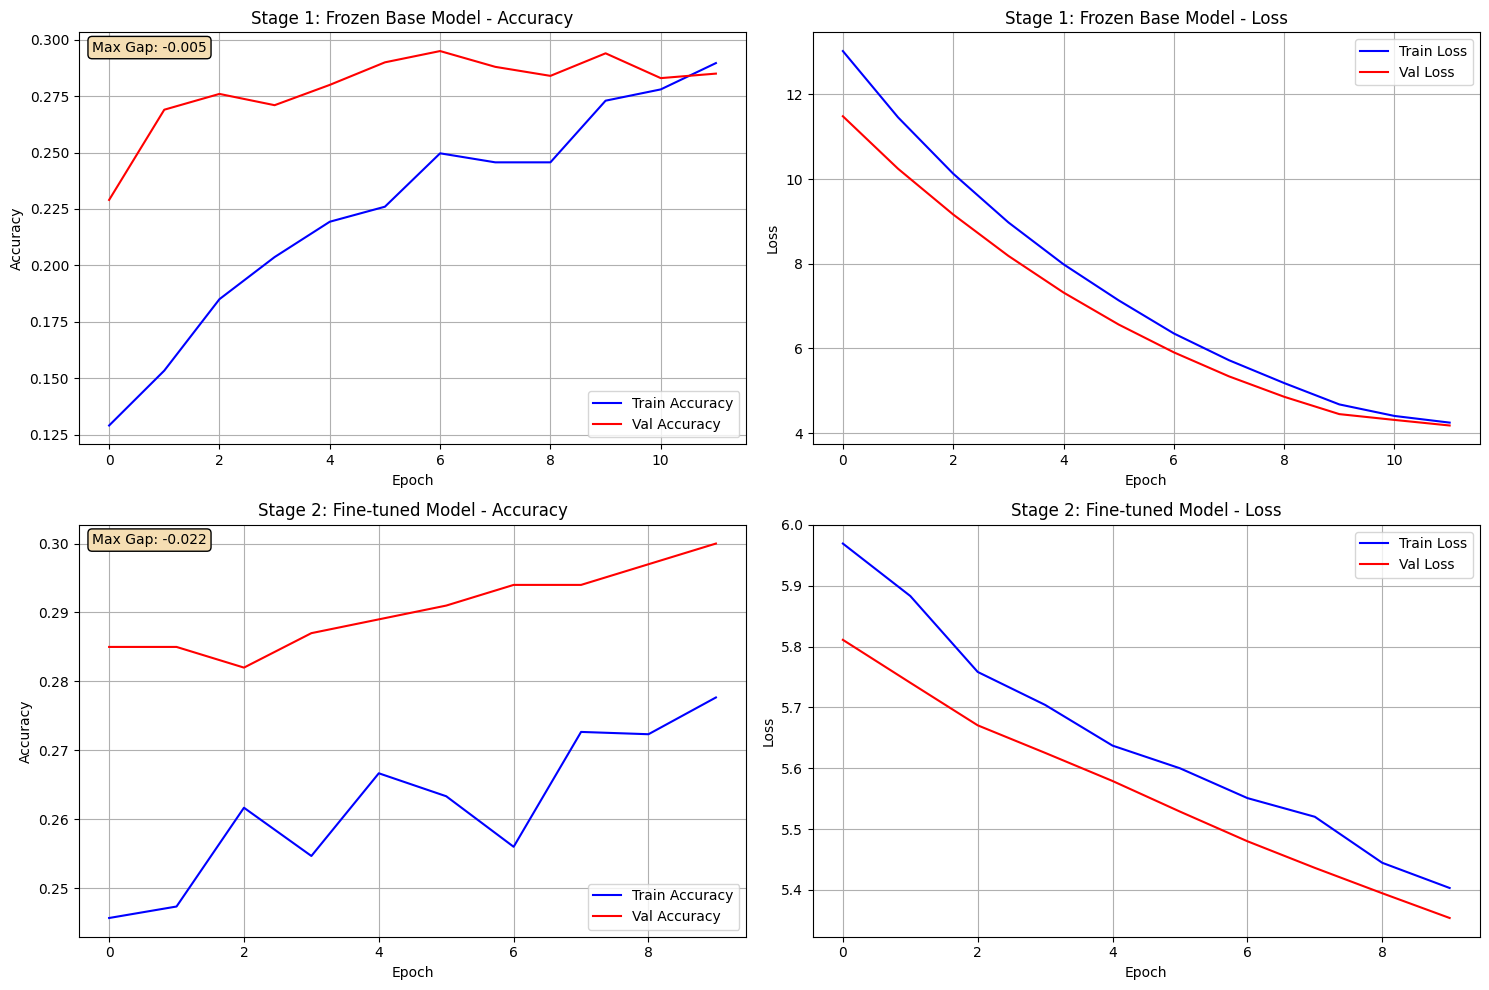

FINAL MODEL EVALUATION
Test accuracy: 0.3070

Classification Report:
                           precision    recall  f1-score   support

Biography & Autobiography       0.43      0.36      0.39       100
     Business & Economics       0.21      0.42      0.28       100
                Computers       0.37      0.52      0.43       100
                Education       0.26      0.10      0.14       100
                  Fiction       0.37      0.27      0.31       100
                  History       0.28      0.53      0.37       100
         Juvenile Fiction       0.40      0.53      0.45       100
      Juvenile Nonfiction       0.22      0.07      0.11       100
                 Religion       0.24      0.24      0.24       100
           Social Science       0.25      0.03      0.05       100

                 accuracy                           0.31      1000
                macro avg       0.30      0.31      0.28      1000
             weighted avg       0.30      0.31      0.28  

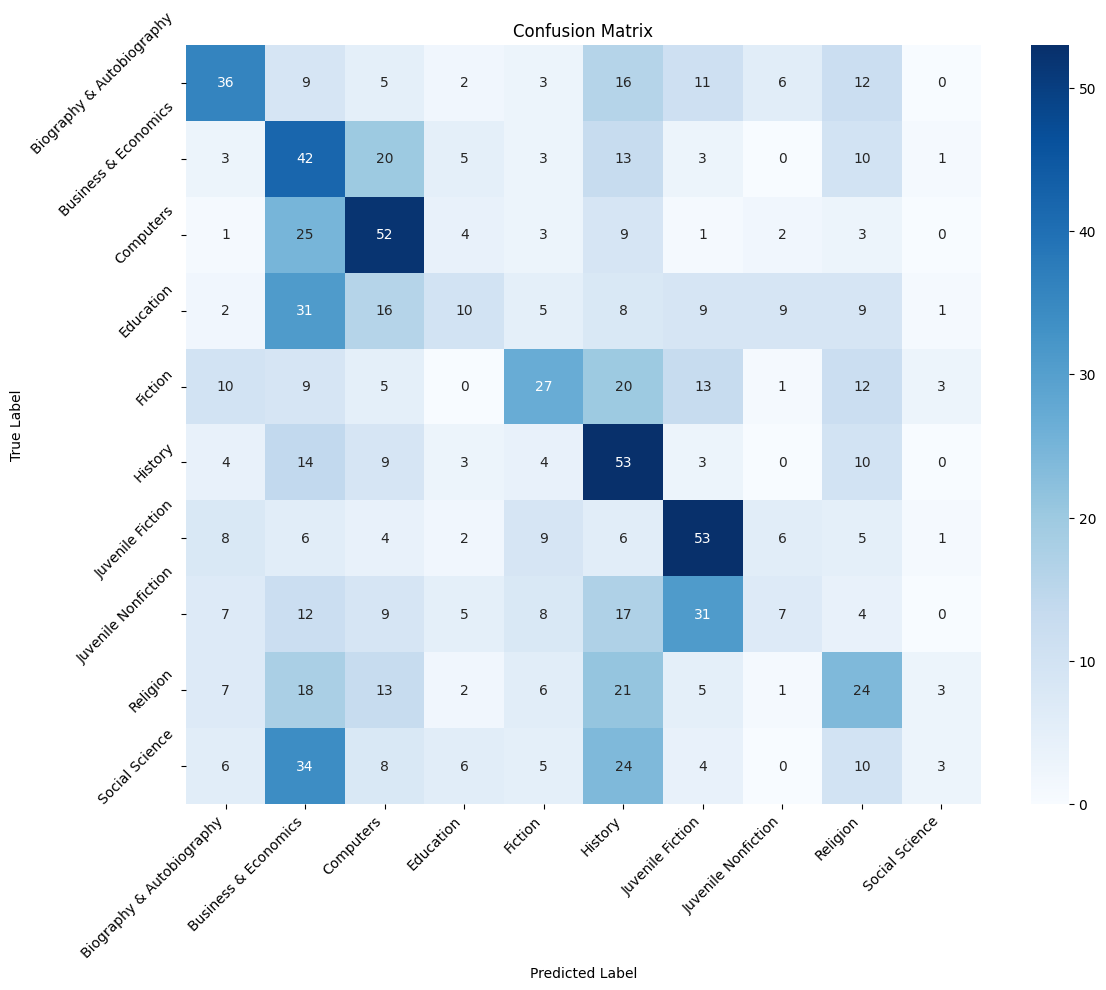

OVERFITTING ANALYSIS
Final Training Accuracy: 0.2777
Final Validation Accuracy: 0.3000
Final Test Accuracy: 0.3070
Train-Val Gap: -0.0223
Val-Test Gap: -0.0070


In [12]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
CACHE_DIR = 'book_cover_cache'
USE_SUBSAMPLING = True
SUBSAMPLE_SIZE = 500
CACHE_VERSION = f"{IMG_HEIGHT}x{IMG_WIDTH}_{'sub' if USE_SUBSAMPLING else 'full'}"


# Create cache directory structure
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(os.path.join(CACHE_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(CACHE_DIR, 'metadata'), exist_ok=True)



def get_cache_filename(url):
    """Generate a unique filename based on the URL hash"""
    return hashlib.md5(url.encode()).hexdigest() + '.jpg'

def get_cached_image_path(url):
    """Check if image is cached and return path if it exists"""
    filename = get_cache_filename(url)
    filepath = os.path.join(CACHE_DIR, 'images', filename)
    if os.path.exists(filepath):
        return filepath
    return None

def download_and_cache_image(url):
    """Download an image and cache it if not already cached"""
    cache_path = get_cached_image_path(url)
    if cache_path is not None:
        return cache_path

    filename = get_cache_filename(url)
    cache_path = os.path.join(CACHE_DIR, 'images', filename)

    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB')
            img = img.resize((IMG_HEIGHT, IMG_WIDTH))
            img.save(cache_path)
            return cache_path
        else:
            return None
    except Exception as e:
        print(f"Error downloading image {url}: {e}")
        return None

def load_cached_image(image_path):
    """Load and preprocess a cached image with size validation"""
    try:
        img = Image.open(image_path)

        if img.mode != 'RGB':
            img = img.convert('RGB')

        if img.size != (IMG_WIDTH, IMG_HEIGHT):
            img = img.resize((IMG_WIDTH, IMG_HEIGHT))

        img_array = np.array(img) / 255.0

        if img_array.shape != (IMG_HEIGHT, IMG_WIDTH, 3):
            return None

        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def cache_dataset_metadata(dataset_name, data):
    """Cache dataset metadata to avoid reprocessing"""
    cache_suffix = '_sub' if USE_SUBSAMPLING else '_full'
    metadata_path = os.path.join(CACHE_DIR, 'metadata', f'{dataset_name}_metadata{cache_suffix}.json')

    cache_data = {
        'image_paths': data['image_path'].to_dict(),
        'encoded_categories': data['encoded_category'].to_dict(),
        'primary_categories': data['primary_category'].to_dict()
    }

    with open(metadata_path, 'w') as f:
        json.dump(cache_data, f)

def load_cached_dataset_metadata(dataset_name):
    """Load cached dataset metadata if it exists"""
    cache_suffix = '_sub' if USE_SUBSAMPLING else '_full'
    metadata_path = os.path.join(CACHE_DIR, 'metadata', f'{dataset_name}_metadata{cache_suffix}.json')
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            return json.load(f)
    return None

def is_dataset_cached():
    """Check if all necessary dataset files are cached"""
    cache_suffix = '_sub' if USE_SUBSAMPLING else '_full'
    required_files = [
        os.path.join(CACHE_DIR, 'metadata', f'train_metadata{cache_suffix}.json'),
        os.path.join(CACHE_DIR, 'metadata', f'val_metadata{cache_suffix}.json'),
        os.path.join(CACHE_DIR, 'metadata', f'test_metadata{cache_suffix}.json'),
        os.path.join(CACHE_DIR, 'metadata', f'category_mapping{cache_suffix}.json')
    ]
    return all(os.path.exists(f) for f in required_files)

def cache_category_mapping(mapping):
    """Cache category mapping to file"""
    cache_suffix = '_sub' if USE_SUBSAMPLING else '_full'
    mapping_path = os.path.join(CACHE_DIR, 'metadata', f'category_mapping{cache_suffix}.json')
    with open(mapping_path, 'w') as f:
        json.dump(mapping, f)

def load_cached_category_mapping():
    """Load cached category mapping if it exists"""
    cache_suffix = '_sub' if USE_SUBSAMPLING else '_full'
    mapping_path = os.path.join(CACHE_DIR, 'metadata', f'category_mapping{cache_suffix}.json')
    if os.path.exists(mapping_path):
        with open(mapping_path, 'r') as f:
            return json.load(f)
    return None

def subsample_data_stratified(data, samples_per_category=500):
    print(f"\n Applying stratified subsampling ({samples_per_category} samples per category):")

    subsampled_data = []
    category_counts = data['primary_category'].value_counts()

    print("Subsampling summary:")
    for category in category_counts.index:
        category_data = data[data['primary_category'] == category]
        original_count = len(category_data)

        if original_count <= samples_per_category:
            # Use all available samples if less than desired amount
            sampled_data = category_data
            sampled_count = original_count
        else:
            # Randomly sample the desired amount
            sampled_data = category_data.sample(n=samples_per_category, random_state=42)
            sampled_count = samples_per_category

        subsampled_data.append(sampled_data)
        print(f"  {category}: {original_count} → {sampled_count} samples")

    result = pd.concat(subsampled_data, ignore_index=True)

    # Shuffle the combined data
    result = result.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Total samples: {len(data)} → {len(result)}")
    return result

def process_data():
    """Process the dataset with caching"""

    if is_dataset_cached():
        train_data = load_cached_dataset_metadata('train')
        val_data = load_cached_dataset_metadata('val')
        test_data = load_cached_dataset_metadata('test')
        category_mapping = load_cached_category_mapping()
        category_mapping = {int(k): v for k, v in category_mapping.items()}

        dataset_type = "SUBSAMPLED" if USE_SUBSAMPLING else "FULL"
        return train_data, val_data, test_data, category_mapping

    dataset_type = "SUBSAMPLED" if USE_SUBSAMPLING else "FULL"
    books_data = pd.read_csv('books_data.csv')
    books_data = books_data[['image', 'categories']]
    filtered_data = books_data.dropna()

    def extract_primary_category(category_str):
        try:
            categories = category_str.strip('[]').replace("'", "").split(', ')
            return categories[0]
        except:
            return None

    filtered_data['primary_category'] = filtered_data['categories'].apply(extract_primary_category)
    filtered_data = filtered_data.dropna(subset=['primary_category'])
    print(f"After filtering missing values and extracting primary categories: {filtered_data.shape}")

    category_counts = filtered_data['primary_category'].value_counts()
    print("\nTop 10 categories:")
    print(category_counts.head(10))

    N_TOP_CATEGORIES = 10
    top_categories = category_counts.head(N_TOP_CATEGORIES).index.tolist()
    filtered_data = filtered_data[filtered_data['primary_category'].isin(top_categories)]
    print(f"After selecting top {N_TOP_CATEGORIES} categories: {filtered_data.shape}")

    # APPLY SUBSAMPLING
    if USE_SUBSAMPLING:
        filtered_data = subsample_data_stratified(filtered_data, SUBSAMPLE_SIZE)
        print(f"After subsampling: {filtered_data.shape}")
    else:
        print("Using full dataset (no subsampling)")


    label_encoder = LabelEncoder()
    filtered_data['encoded_category'] = label_encoder.fit_transform(filtered_data['primary_category'])

    category_mapping = {i: category for i, category in enumerate(label_encoder.classes_)}
    print("\nCategory mapping:")
    for encoded, original in category_mapping.items():
        print(f"{encoded}: {original}")

    cache_category_mapping(category_mapping)

    train_val_data, test_data = train_test_split(
        filtered_data,
        test_size=0.2,
        random_state=42,
        stratify=filtered_data['encoded_category']
    )

    train_data, val_data = train_test_split(
        train_val_data,
        test_size=0.25,
        random_state=42,
        stratify=train_val_data['encoded_category']
    )

    print(f"\n Dataset split summary:")
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")


    train_data['image_path'] = train_data['image'].apply(download_and_cache_image)
    val_data['image_path'] = val_data['image'].apply(download_and_cache_image)
    test_data['image_path'] = test_data['image'].apply(download_and_cache_image)

    train_data = train_data.dropna(subset=['image_path'])
    val_data = val_data.dropna(subset=['image_path'])
    test_data = test_data.dropna(subset=['image_path'])

    print(f"After filtering missing images:")
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")

    cache_dataset_metadata('train', train_data)
    cache_dataset_metadata('val', val_data)
    cache_dataset_metadata('test', test_data)

    return train_data, val_data, test_data, category_mapping

class BookCoverDataGenerator(tf.keras.utils.Sequence):
    """data augmentation to prevent overfitting"""
    def __init__(self, data, batch_size=32, shuffle=True, augment=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

        if isinstance(data, dict):
            self.image_paths = list(data['image_paths'].values())
            self.encoded_categories = list(data['encoded_categories'].values())
        else:
            self.image_paths = data['image_path'].tolist()
            self.encoded_categories = data['encoded_category'].tolist()

        self.n = len(self.image_paths)
        self.indexes = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indexes)

        # Data augmentation
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                brightness_range=[0.8, 1.2],
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.zeros((len(batch_indexes), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        batch_y = np.zeros(len(batch_indexes), dtype=np.int32)

        valid_samples = 0
        for i, idx in enumerate(batch_indexes):
            img_array = load_cached_image(self.image_paths[idx])
            if img_array is not None and img_array.shape == (IMG_HEIGHT, IMG_WIDTH, 3):

                # Apply data augmentation
                if self.augment:
                    # Convert to uint8 for ImageDataGenerator
                    img_uint8 = (img_array * 255).astype(np.uint8)
                    img_uint8 = np.expand_dims(img_uint8, axis=0)

                    # Apply random transformation
                    augmented = next(self.datagen.flow(img_uint8, batch_size=1))
                    img_array = augmented[0] / 255.0

                batch_x[valid_samples] = img_array
                batch_y[valid_samples] = self.encoded_categories[idx]
                valid_samples += 1

        if valid_samples < len(batch_indexes):
            batch_x = batch_x[:valid_samples]
            batch_y = batch_y[:valid_samples]

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

def transfer_learning_model(dropout_rate=0.7, learning_rate=0.001,
                                          trainable_layers=0, num_classes=10,
                                          l2_reg=0.01):
    """Create transfer learning model with better regularization"""
    base_model = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    base_model.trainable = False

    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    # architecture with more regularization
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),

        # First dense layer with L2 regularization
        layers.Dense(512, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),

        # Second dense layer
        layers.Dense(256, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate * 0.8),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# callback to track best weights without saving to disk
class BestWeightsTracker(callbacks.Callback):
    def __init__(self, monitor='val_accuracy', mode='max'):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.best_weights = None
        self.best_value = -np.inf if mode == 'max' else np.inf

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        if current_value is None:
            return

        if ((self.mode == 'max' and current_value > self.best_value) or
            (self.mode == 'min' and current_value < self.best_value)):
            self.best_value = current_value
            self.best_weights = self.model.get_weights()
            print(f"\nEpoch {epoch + 1}: {self.monitor} improved to {current_value:.4f}, saving weights")

    def restore_best_weights(self):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restored best weights with {self.monitor}: {self.best_value:.4f}")


def evaluate_model(model, test_generator, category_mapping):
    """Evaluate model on test set and visualize results"""

    y_true = []
    y_pred = []

    for i in range(len(test_generator)):
        x_batch, y_batch = test_generator[i]
        if len(x_batch) > 0:
            batch_preds = model.predict(x_batch, verbose=0)
            batch_pred_classes = np.argmax(batch_preds, axis=1)

            y_true.extend(y_batch)
            y_pred.extend(batch_pred_classes)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = np.mean(y_pred == y_true)
    print(f"Test accuracy: {accuracy:.4f}")

    class_names = [category_mapping[i] for i in range(len(category_mapping))]
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, report, cm, y_true, y_pred

def plot_overfitting_analysis(history_stage1, history_stage2=None):
    """Plot training history with overfitting analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Stage 1 plots
    train_acc = history_stage1.history['accuracy']
    val_acc = history_stage1.history['val_accuracy']
    train_loss = history_stage1.history['loss']
    val_loss = history_stage1.history['val_loss']

    axes[0, 0].plot(train_acc, label='Train Accuracy', color='blue')
    axes[0, 0].plot(val_acc, label='Val Accuracy', color='red')
    axes[0, 0].set_title('Stage 1: Frozen Base Model - Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Add overfitting indicator
    gap = max(train_acc) - max(val_acc)
    axes[0, 0].text(0.02, 0.98, f'Max Gap: {gap:.3f}', transform=axes[0, 0].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

    axes[0, 1].plot(train_loss, label='Train Loss', color='blue')
    axes[0, 1].plot(val_loss, label='Val Loss', color='red')
    axes[0, 1].set_title('Stage 1: Frozen Base Model - Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    if history_stage2:
        train_acc2 = history_stage2.history['accuracy']
        val_acc2 = history_stage2.history['val_accuracy']
        train_loss2 = history_stage2.history['loss']
        val_loss2 = history_stage2.history['val_loss']

        axes[1, 0].plot(train_acc2, label='Train Accuracy', color='blue')
        axes[1, 0].plot(val_acc2, label='Val Accuracy', color='red')
        axes[1, 0].set_title('Stage 2: Fine-tuned Model - Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Add overfitting indicator
        gap2 = max(train_acc2) - max(val_acc2)
        axes[1, 0].text(0.02, 0.98, f'Max Gap: {gap2:.3f}', transform=axes[1, 0].transAxes,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

        axes[1, 1].plot(train_loss2, label='Train Loss', color='blue')
        axes[1, 1].plot(val_loss2, label='Val Loss', color='red')
        axes[1, 1].set_title('Stage 2: Fine-tuned Model - Loss')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    else:
        axes[1, 0].set_visible(False)
        axes[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()

def main():
    dataset_type = "SUBSAMPLED" if USE_SUBSAMPLING else "FULL"
    print(f"BOOK COVER CLASSIFICATION - {dataset_type} DATASET")

    # Step 1: Process data
    train_data, val_data, test_data, category_mapping = process_data()

    # Step 2: Create data generators with augmentation
    train_generator = BookCoverDataGenerator(
        train_data, batch_size=BATCH_SIZE, shuffle=True, augment=True
    )
    val_generator = BookCoverDataGenerator(
        val_data, batch_size=BATCH_SIZE, shuffle=False, augment=False
    )
    test_generator = BookCoverDataGenerator(
        test_data, batch_size=BATCH_SIZE, shuffle=False, augment=False
    )


    # Step 3: STAGE 1 - Train with frozen base model
    print("STAGE 1: TRAINING WITH FROZEN BASE MODEL")

    model = transfer_learning_model(
        dropout_rate=0.7,
        learning_rate=0.0005,
        trainable_layers=0,
        num_classes=len(category_mapping),
        l2_reg=0.01
    )

    print("model architecture:")
    model.summary()

    # callback to track best weights
    best_weights_tracker = BestWeightsTracker(monitor='val_accuracy', mode='max')

    # callbacks without model checkpointing
    callbacks_stage1 = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.3,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        best_weights_tracker
    ]

    # Train stage 1
    history_stage1 = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=callbacks_stage1,
        verbose=1
    )

    # Restore best weights from stage 1
    best_weights_tracker.restore_best_weights()

    # Step 4: STAGE 2 - Conservative fine-tuning
    print("STAGE 2: CONSERVATIVE FINE-TUNING")

    # Unfreeze only a few top layers
    base_model = model.layers[0]
    base_model.trainable = True

    # Freeze all layers except the top 10
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}")

    # Recompile with lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.00005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # New tracker for stage 2
    best_weights_tracker_stage2 = BestWeightsTracker(monitor='val_accuracy', mode='max')

    # Conservative callbacks for stage 2
    callbacks_stage2 = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=2,
            min_lr=1e-8,
            verbose=1
        ),
        best_weights_tracker_stage2
    ]

    # Conservative fine-tuning
    history_stage2 = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=callbacks_stage2,
        verbose=1
    )

    # Restore best weights from stage 2
    best_weights_tracker_stage2.restore_best_weights()

    # Step 5: Plot training history with overfitting analysis
    plot_overfitting_analysis(history_stage1, history_stage2)

    # Step 6: Final evaluation
    print("FINAL MODEL EVALUATION")

    test_acc, test_report, test_cm, y_true, y_pred = evaluate_model(
        model, test_generator, category_mapping
    )

    # Overfitting analysis
    print("OVERFITTING ANALYSIS")

    final_train_acc = history_stage2.history['accuracy'][-1] if history_stage2 else history_stage1.history['accuracy'][-1]
    final_val_acc = history_stage2.history['val_accuracy'][-1] if history_stage2 else history_stage1.history['val_accuracy'][-1]

    train_val_gap = final_train_acc - final_val_acc
    val_test_gap = final_val_acc - test_acc

    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Test Accuracy: {test_acc:.4f}")
    print(f"Train-Val Gap: {train_val_gap:.4f}")
    print(f"Val-Test Gap: {val_test_gap:.4f}")

    return model, history_stage1, history_stage2

if __name__ == "__main__":
    final_model, hist1, hist2 = main()
